# 자전거 대여량 예측 모델

# LinearRegression, RandomForestRegressor
# GradientBoostingClassifier, XGBRegressor, LGBMRRegressor

## 1. 라이브러리 & 모델리스트 & 성능 비교 셋업

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#import missingno as msno

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

results = []


In [3]:

# 시스템 환경에 따라 폰트를 자동으로 설정해주는 함수
def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin":
        return "AppleGothic"
    elif system_name == "Windows":
        return "Malgun Gothic"
    else:
        # Linux (Colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        return "NanumBarunGothic"

# 한글 폰트 적용
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

# 레티나 디스플레이 설정 (선명하게)
%config InlineBackend.figure_format = 'retina'



## 2. 데이터 로딩 및 datetime 처리

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# datetime 파싱 및 파생변수 생성
def datetime_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    return df

train = datetime_features(train)
test = datetime_features(test)
test_id = test['datetime']

# 학습용 데이터 정리
train.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)
test.drop(['datetime'], axis=1, inplace=True)

## 3. Feature / Target 분리 및 로그 변환

In [5]:
from sklearn.model_selection import train_test_split

X = train.drop('count', axis=1)
y = train['count']
y_log = np.log1p(y)  # 로그 변환

X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)


## 4. 다항회귀 모델 (degree별 비교)

In [6]:
for d in range(1, 5):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('linear', LinearRegression())
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    results.append({
        'model': f'Polynomial (deg={d})',
        'mse': mean_squared_error(np.expm1(y_valid), np.expm1(pred)),
        'r2': r2_score(y_valid, pred),
        'degree': d
    })


## 5. LinearRegression, RandomForest, GradientBoosting, XGBRegressor    
### (RMSE, MSE, R²)

In [7]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42)
}

In [8]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_valid)
    pred = np.expm1(pred_log)
    actual = np.expm1(y_valid)

    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, pred_log)

    results.append({
        '모델': name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

df_results = pd.DataFrame(results)
display(df_results)


,모델,MSE,RMSE,R2
0,LinearRegression,25837.809812,160.741438,0.490127
1,RandomForest,1615.454299,40.192715,0.954887
2,GradientBoosting,5744.058278,75.789566,0.922843
3,XGBRegressor,1520.174247,38.989412,0.959714


## 6. 결과 정리 & 시각화

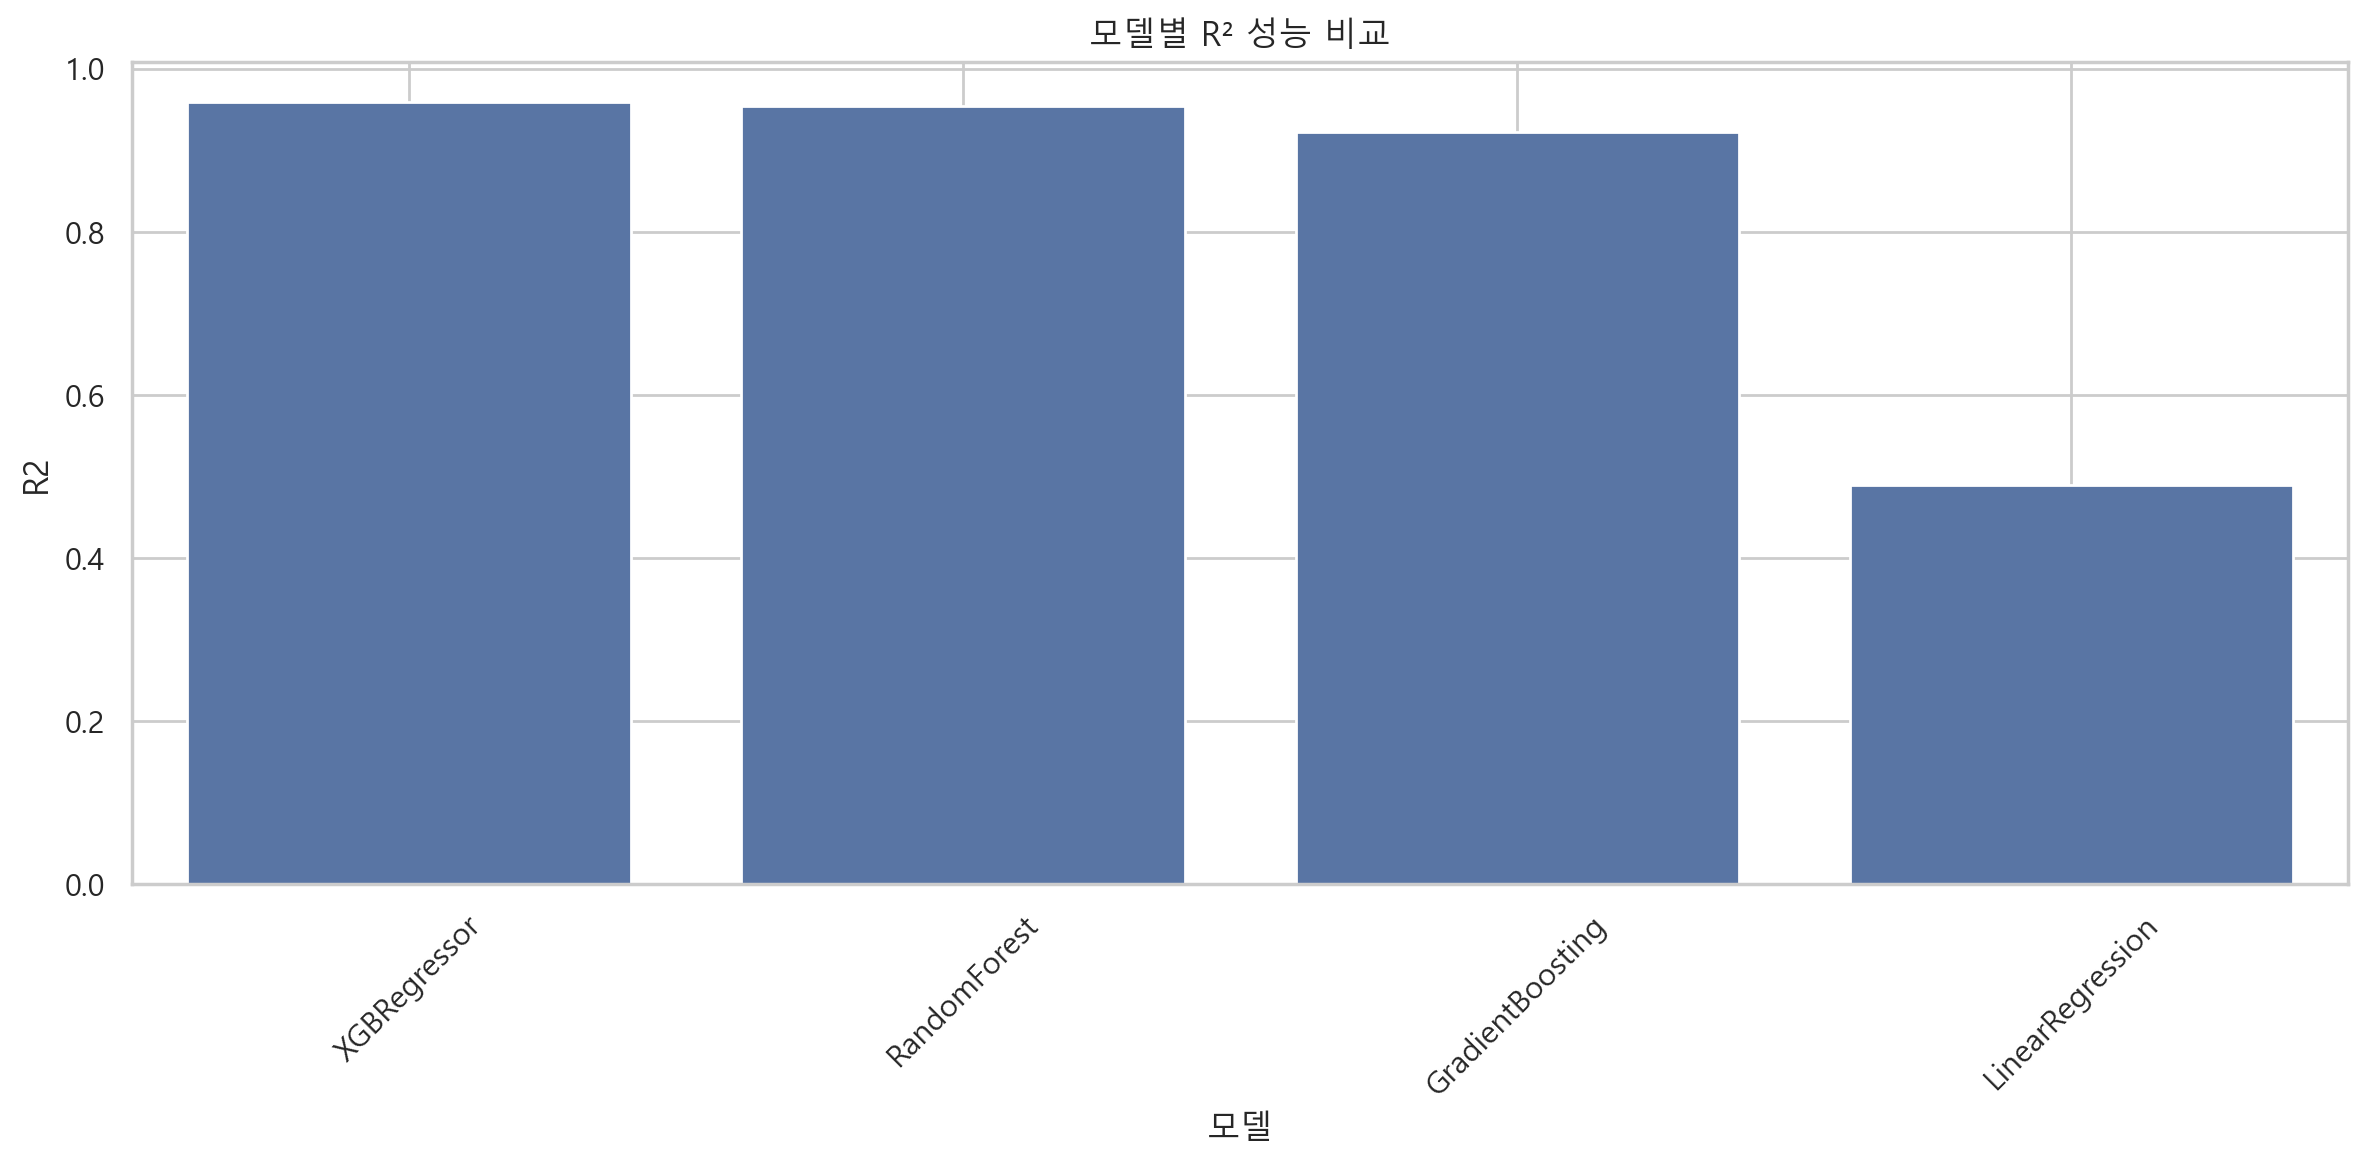

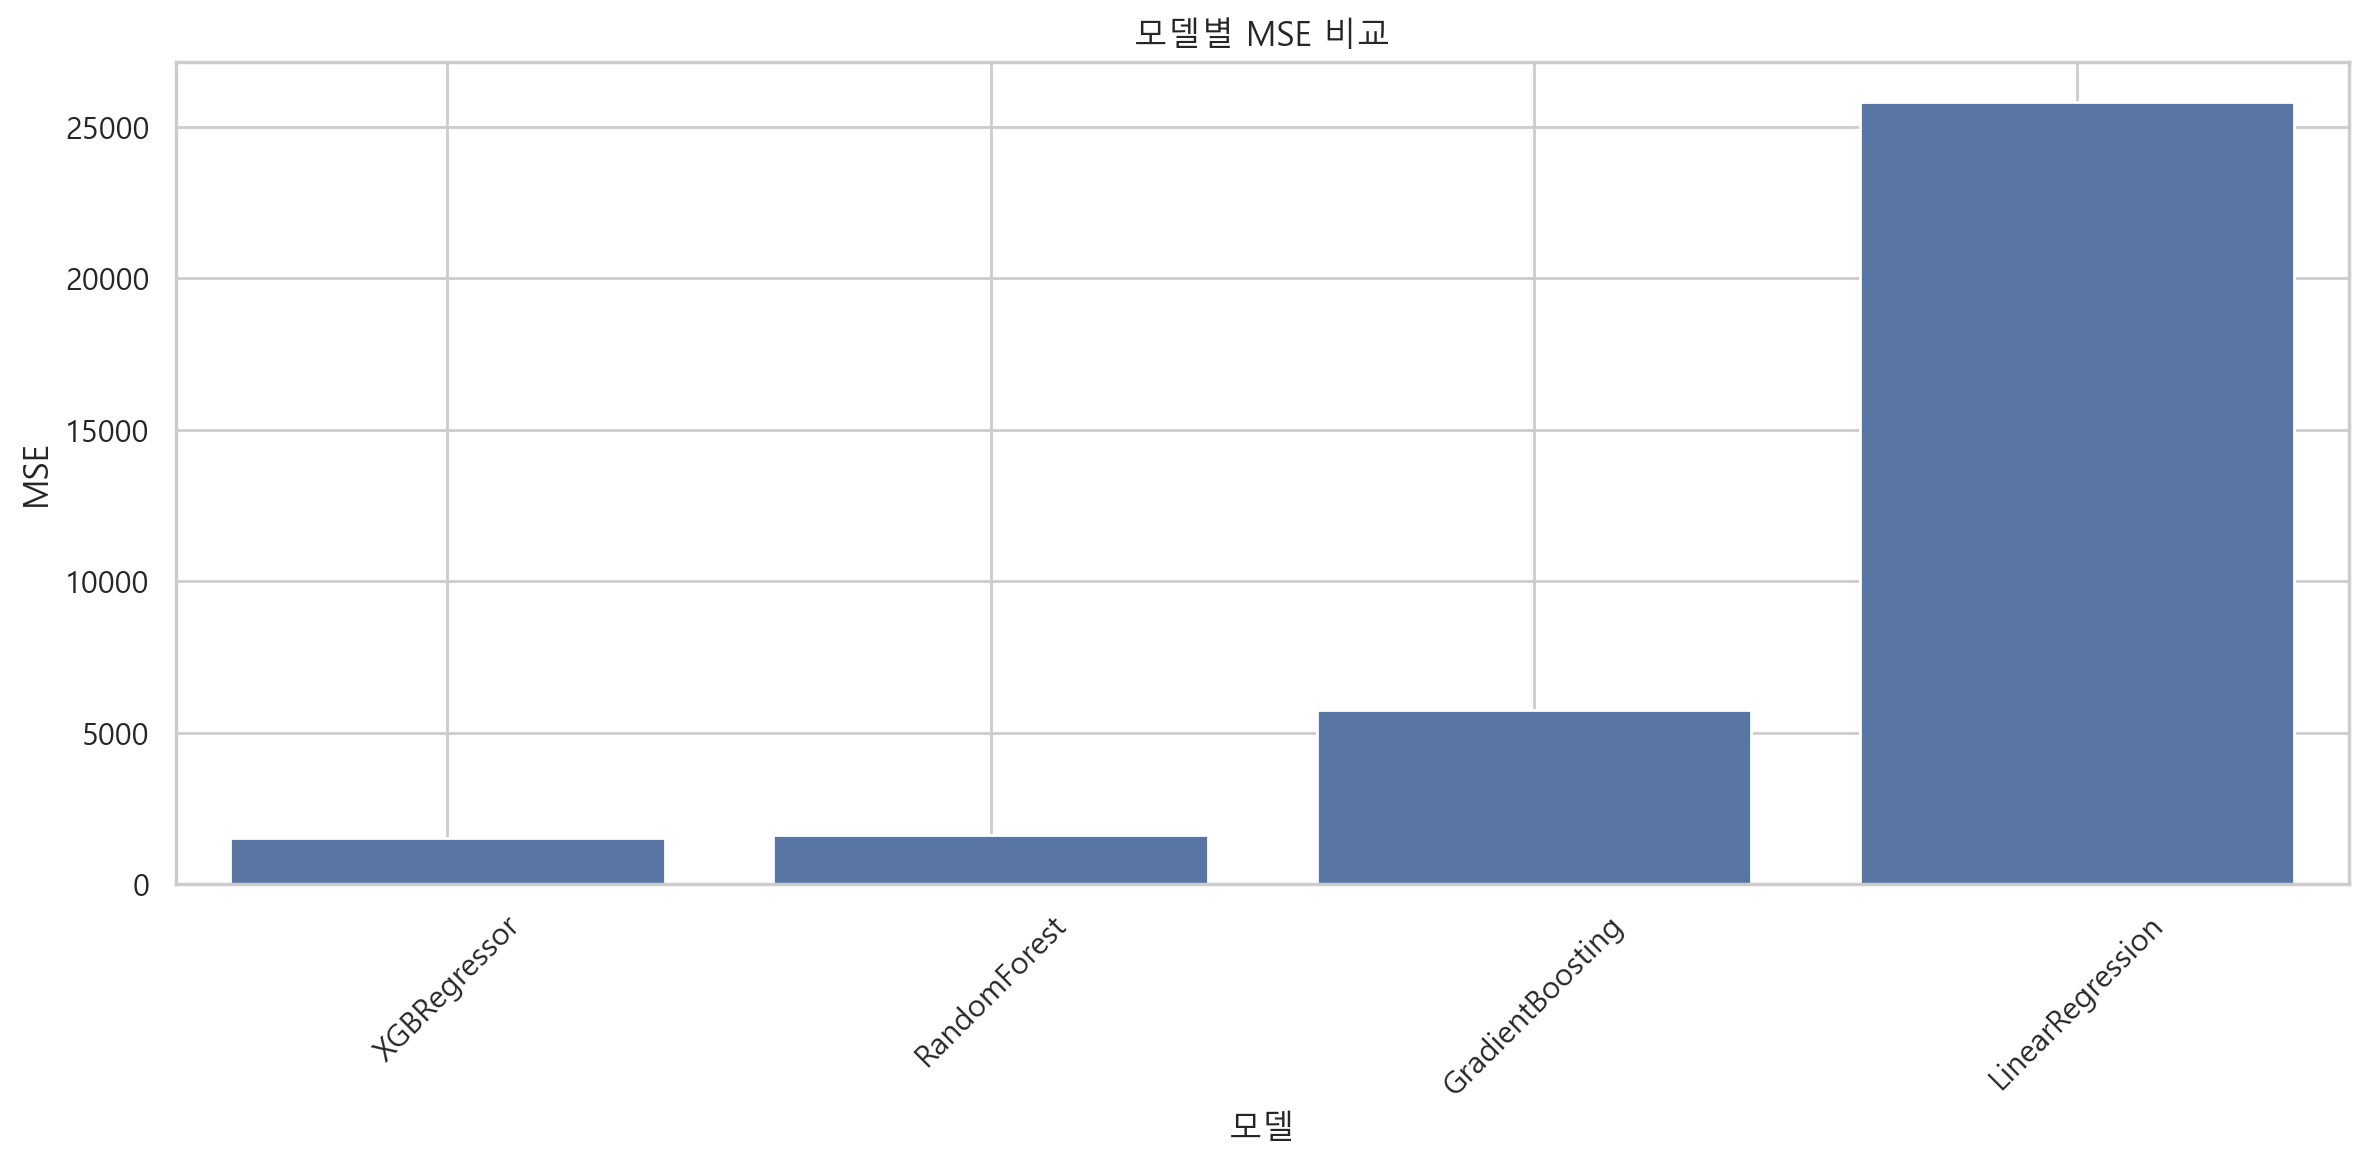

In [9]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False)  # R2로!

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='모델', y='R2')  # R2로!
plt.title('모델별 R² 성능 비교')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='모델', y='MSE')  # MSE도 대문자!
plt.title('모델별 MSE 비교')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 7.  최고 모델 (LinearRegression, RandomForest, GradientBoosting, XGBRegressor)

In [10]:
# 먼저 리스트 → 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 최고 R² 모델 뽑기
best_row = results_df.loc[results_df['R2'].idxmax()]

print("최고 성능 모델:", best_row['모델'])
print(f"최고 R² 점수: {best_row['R2']:.2f}")
print(f"MSE: {best_row['MSE']:.2f}")


최고 성능 모델: XGBRegressor
최고 R² 점수: 0.96
MSE: 1520.17


대표적인 성능 기준   
MSE : 값이 작을수록 좋음   
RMSE : MSE의 루트, 해석력이 좋음   
R² (결정계수) : 값이 1에 가까울수록 좋음   

일반적으로 예측값의 분산을 잘 설명하고 있는지를 보기 때문에   
 R² 점수가 가장 높은 모델을 선택하는 게 기본이다.

최고 성능 모델: XGBRegressor   
최고 R² 점수: 0.96   
MSE: 1520.17

## 8. 다항회귀 + 규제회귀 (MSE, R²)

In [23]:
# 필요한 metric import 누락된 부분 보완
from sklearn.metrics import mean_squared_error, r2_score

# 다항회귀 모델
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression())
])
poly_model.fit(X_train, y_train)
poly_pred_log = poly_model.predict(X_valid)
poly_pred = np.expm1(poly_pred_log)
poly_mse = mean_squared_error(np.expm1(y_valid), poly_pred)
poly_r2 = r2_score(y_valid, poly_pred_log)

results_poly_regularized = [{
    '모델': 'Polynomial Regression',
    'MSE': poly_mse,
    'R2': poly_r2
}]

# 규제 회귀 모델들
reg_models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet()
}

for name, model in reg_models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_valid)
    pred = np.expm1(pred_log)

    mse = mean_squared_error(np.expm1(y_valid), pred)
    r2 = r2_score(y_valid, pred_log)

    results_poly_regularized.append({
        '모델': name,
        'MSE': mse,
        'R2': r2
    })

df_poly_regularized = pd.DataFrame(results_poly_regularized)

df_poly_regularized


,모델,MSE,R2
0,Polynomial Regression,14926.132466,0.634894
1,Ridge Regression,25837.718744,0.490128
2,Lasso Regression,28688.593931,0.431759
3,Elastic Net Regression,27949.437168,0.453096


## 9. 시각화 (다항회귀, 규제회귀)

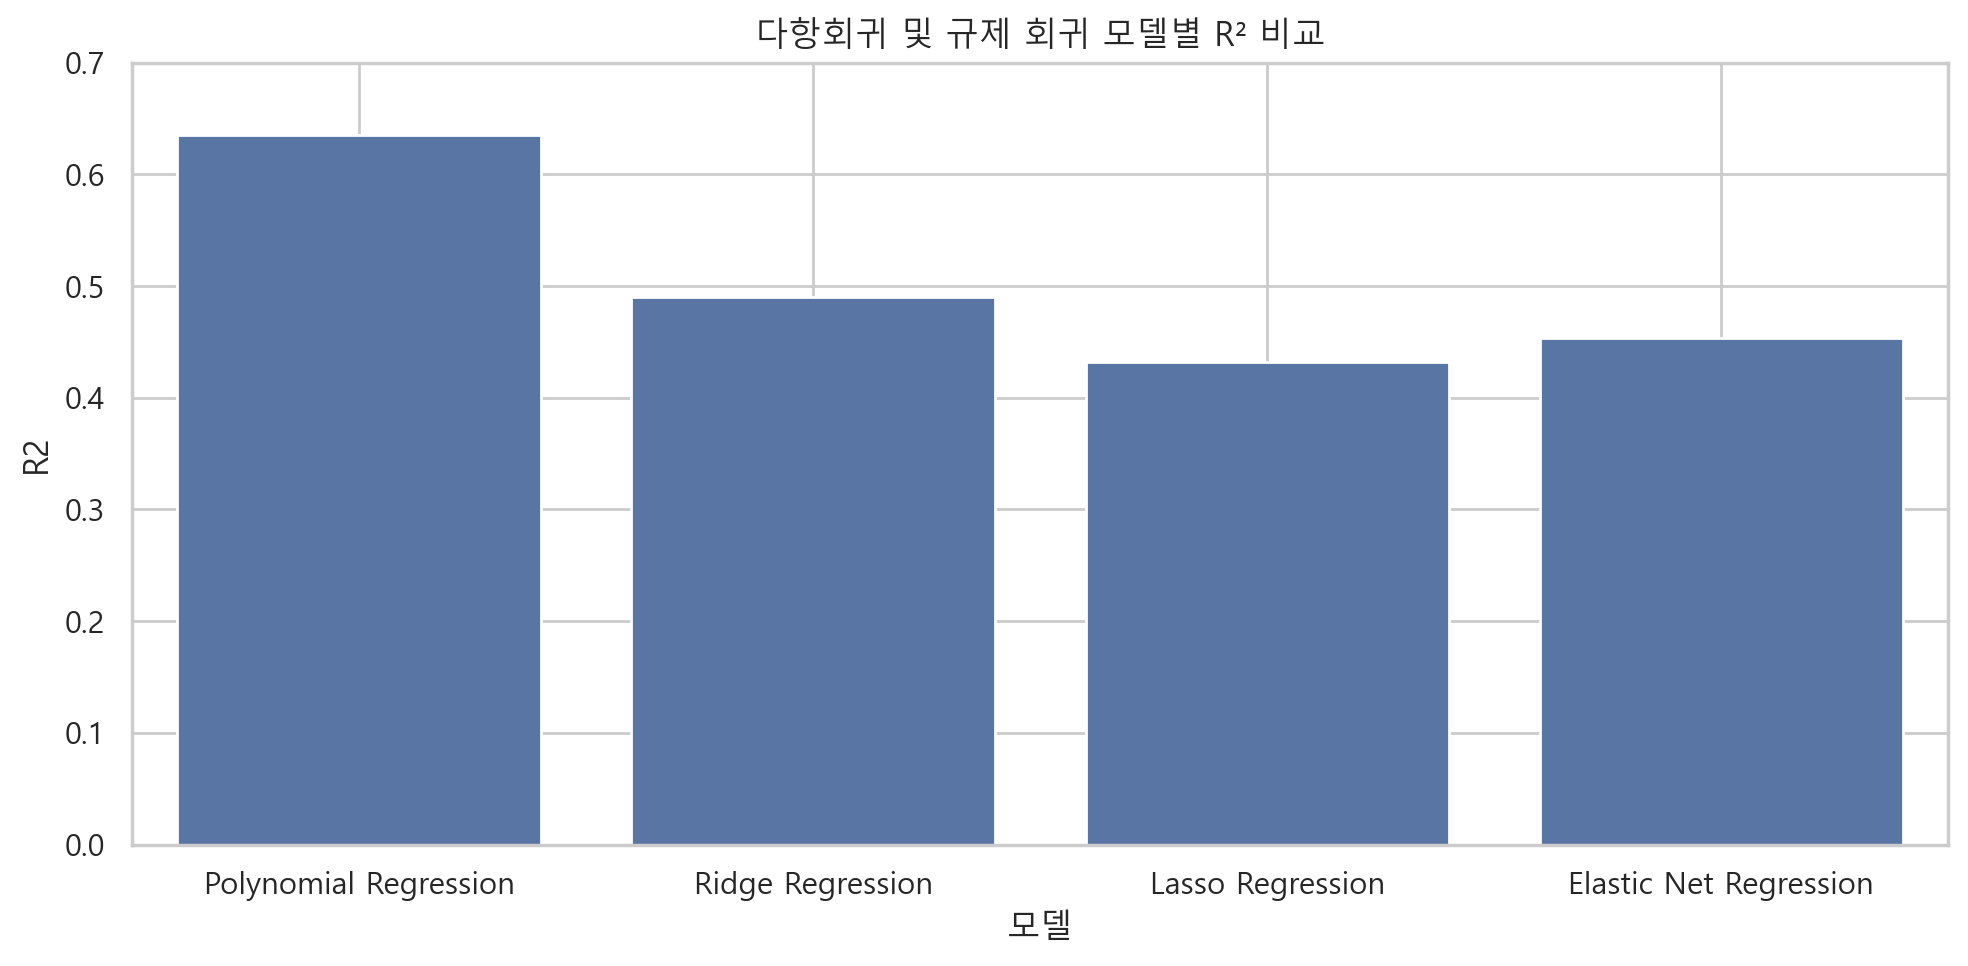

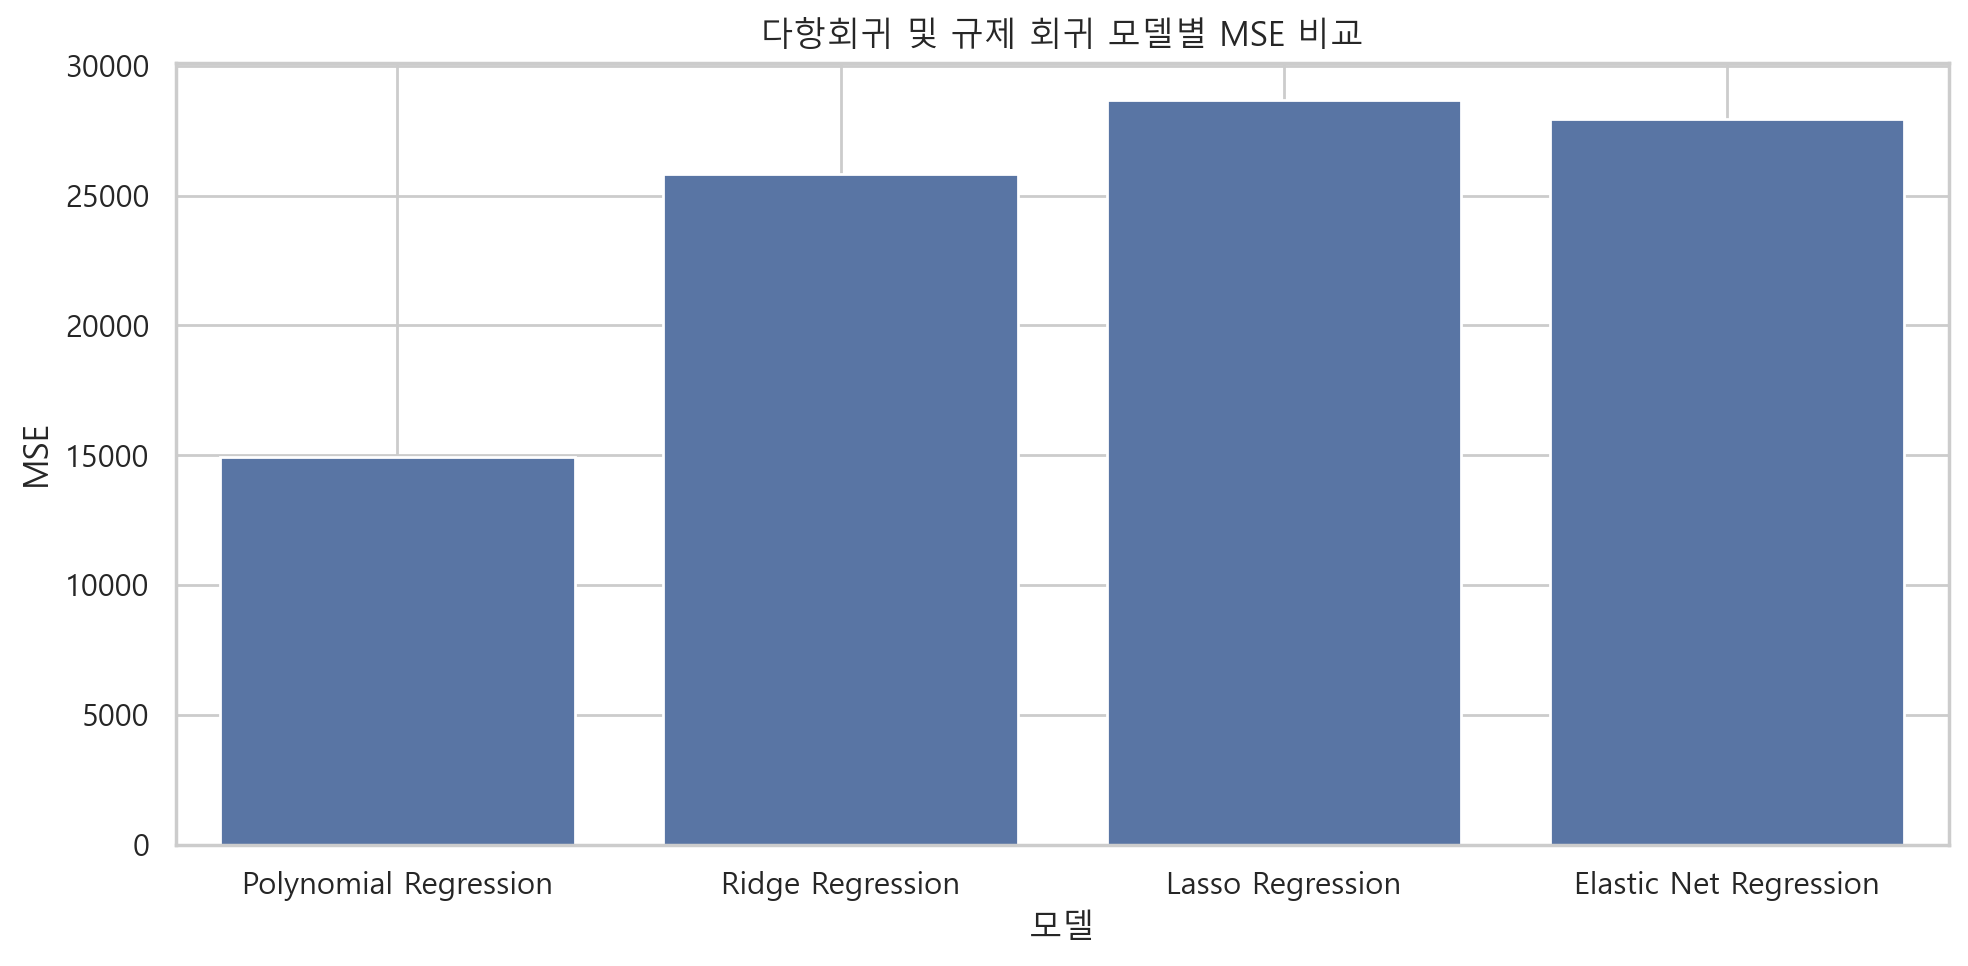

In [24]:


# 다항회귀 및 규제 회귀 성능 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=df_poly_regularized, x='모델', y='R2')
plt.title('다항회귀 및 규제 회귀 모델별 R² 비교')
plt.ylim(0, 0.7)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_poly_regularized, x='모델', y='MSE')
plt.title('다항회귀 및 규제 회귀 모델별 MSE 비교')
plt.grid(True)
plt.tight_layout()
plt.show()


## 10. 최고 모델 (다항회귀, 규제회귀)

In [25]:
def get_best_model_by_r2(df, model_col='모델', r2_col='R2'):
    best_row = df.loc[df[r2_col].idxmax()]
    print("최고 성능 모델:", best_row[model_col])
    print(f"최고 R² 점수: {best_row[r2_col]:.4f}")
    print(f"MSE: {best_row['MSE']:.2f}")
    return best_row


best_model = get_best_model_by_r2(df_poly_regularized)

최고 성능 모델: Polynomial Regression
최고 R² 점수: 0.6349
MSE: 14926.13


## 11. 전체 시각화

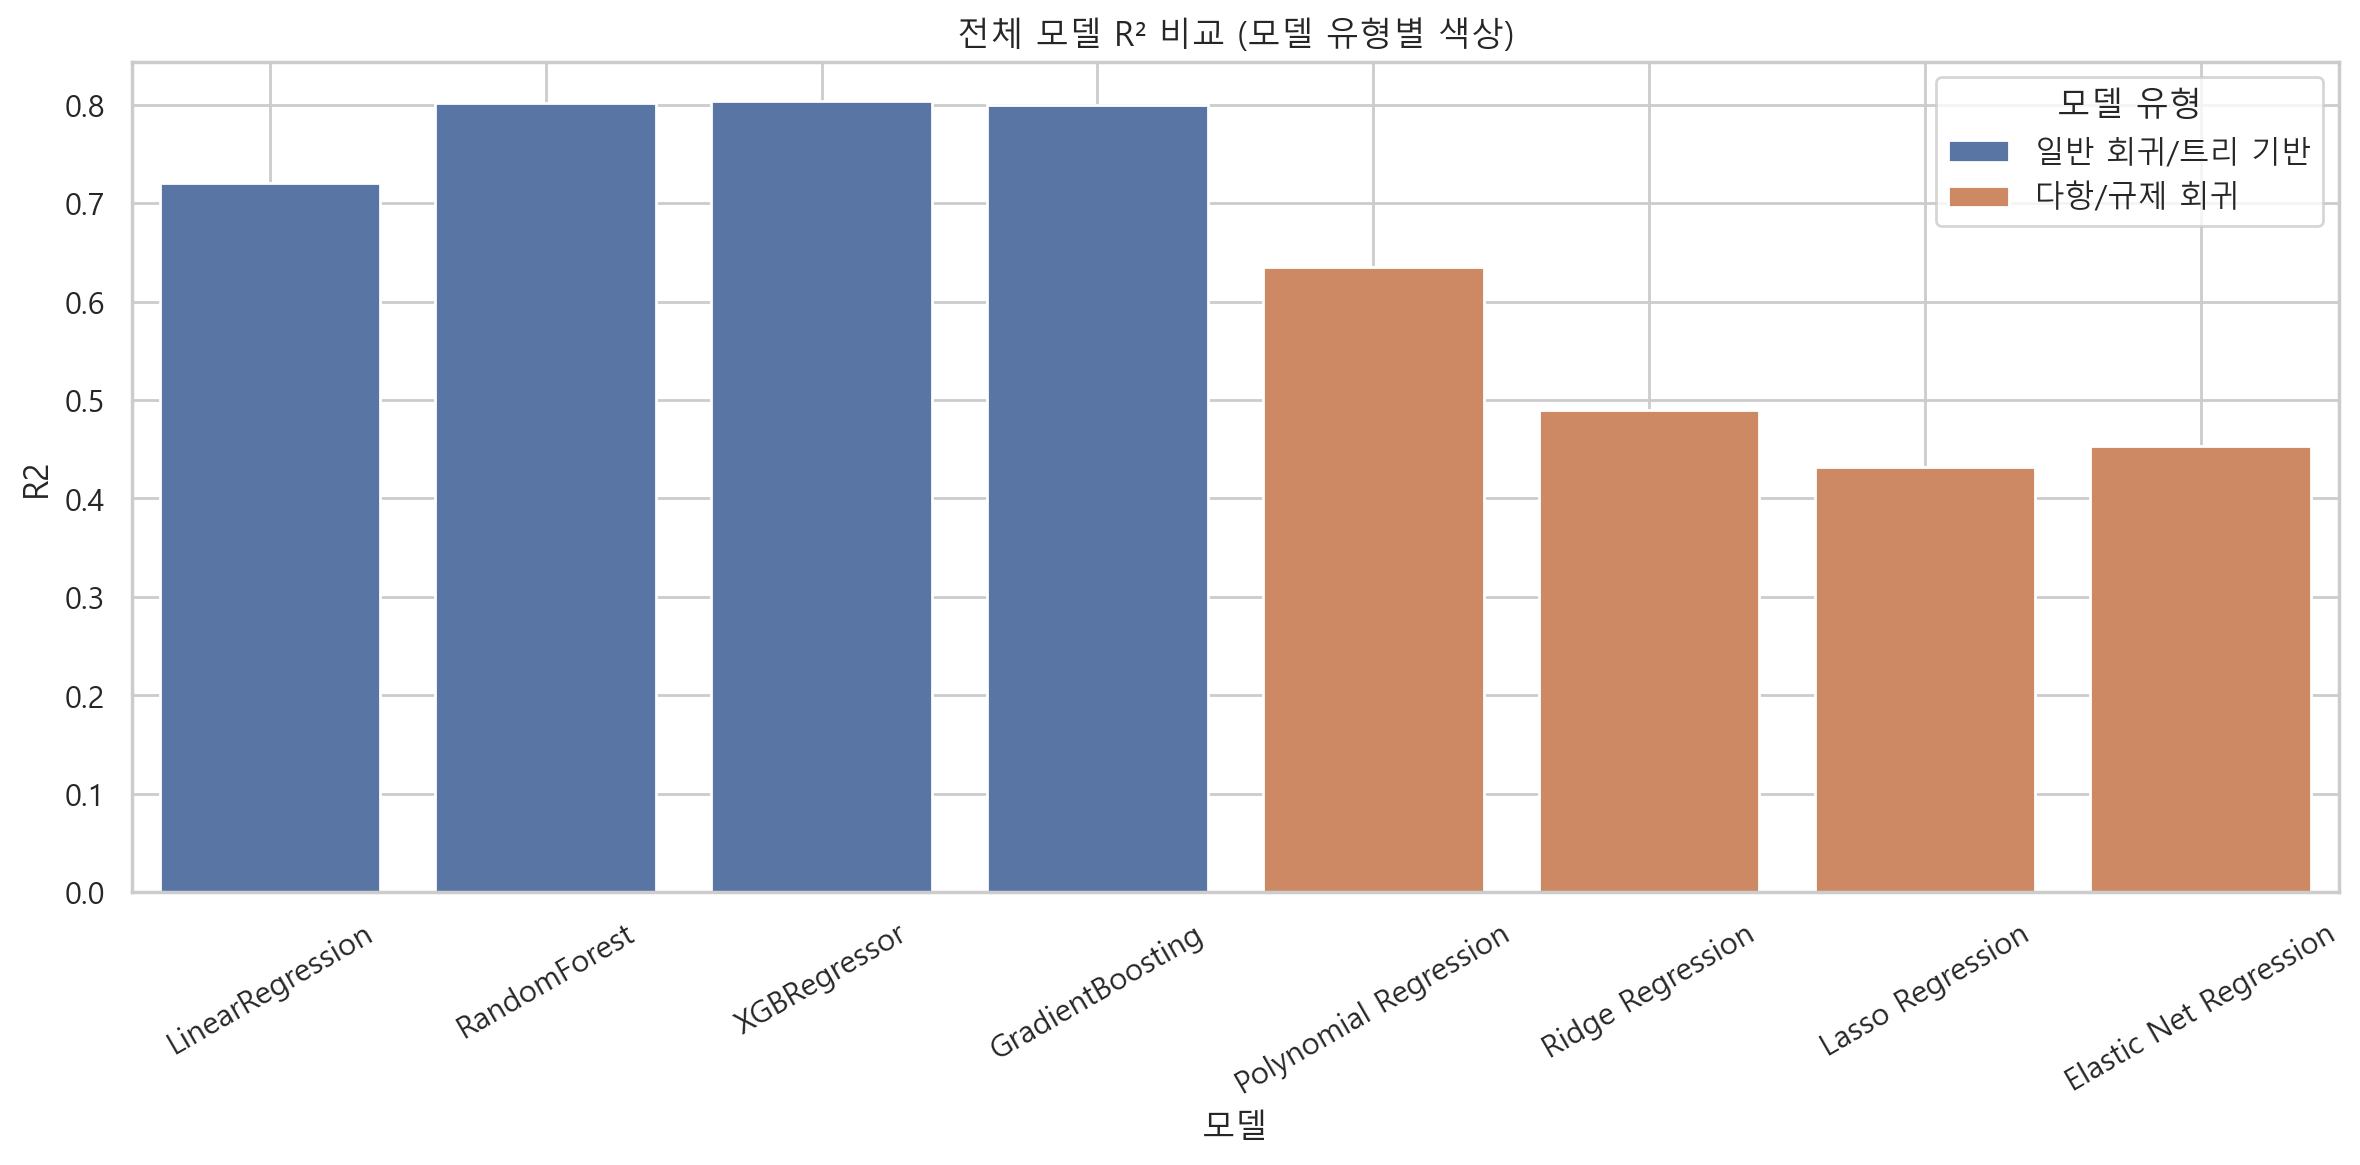

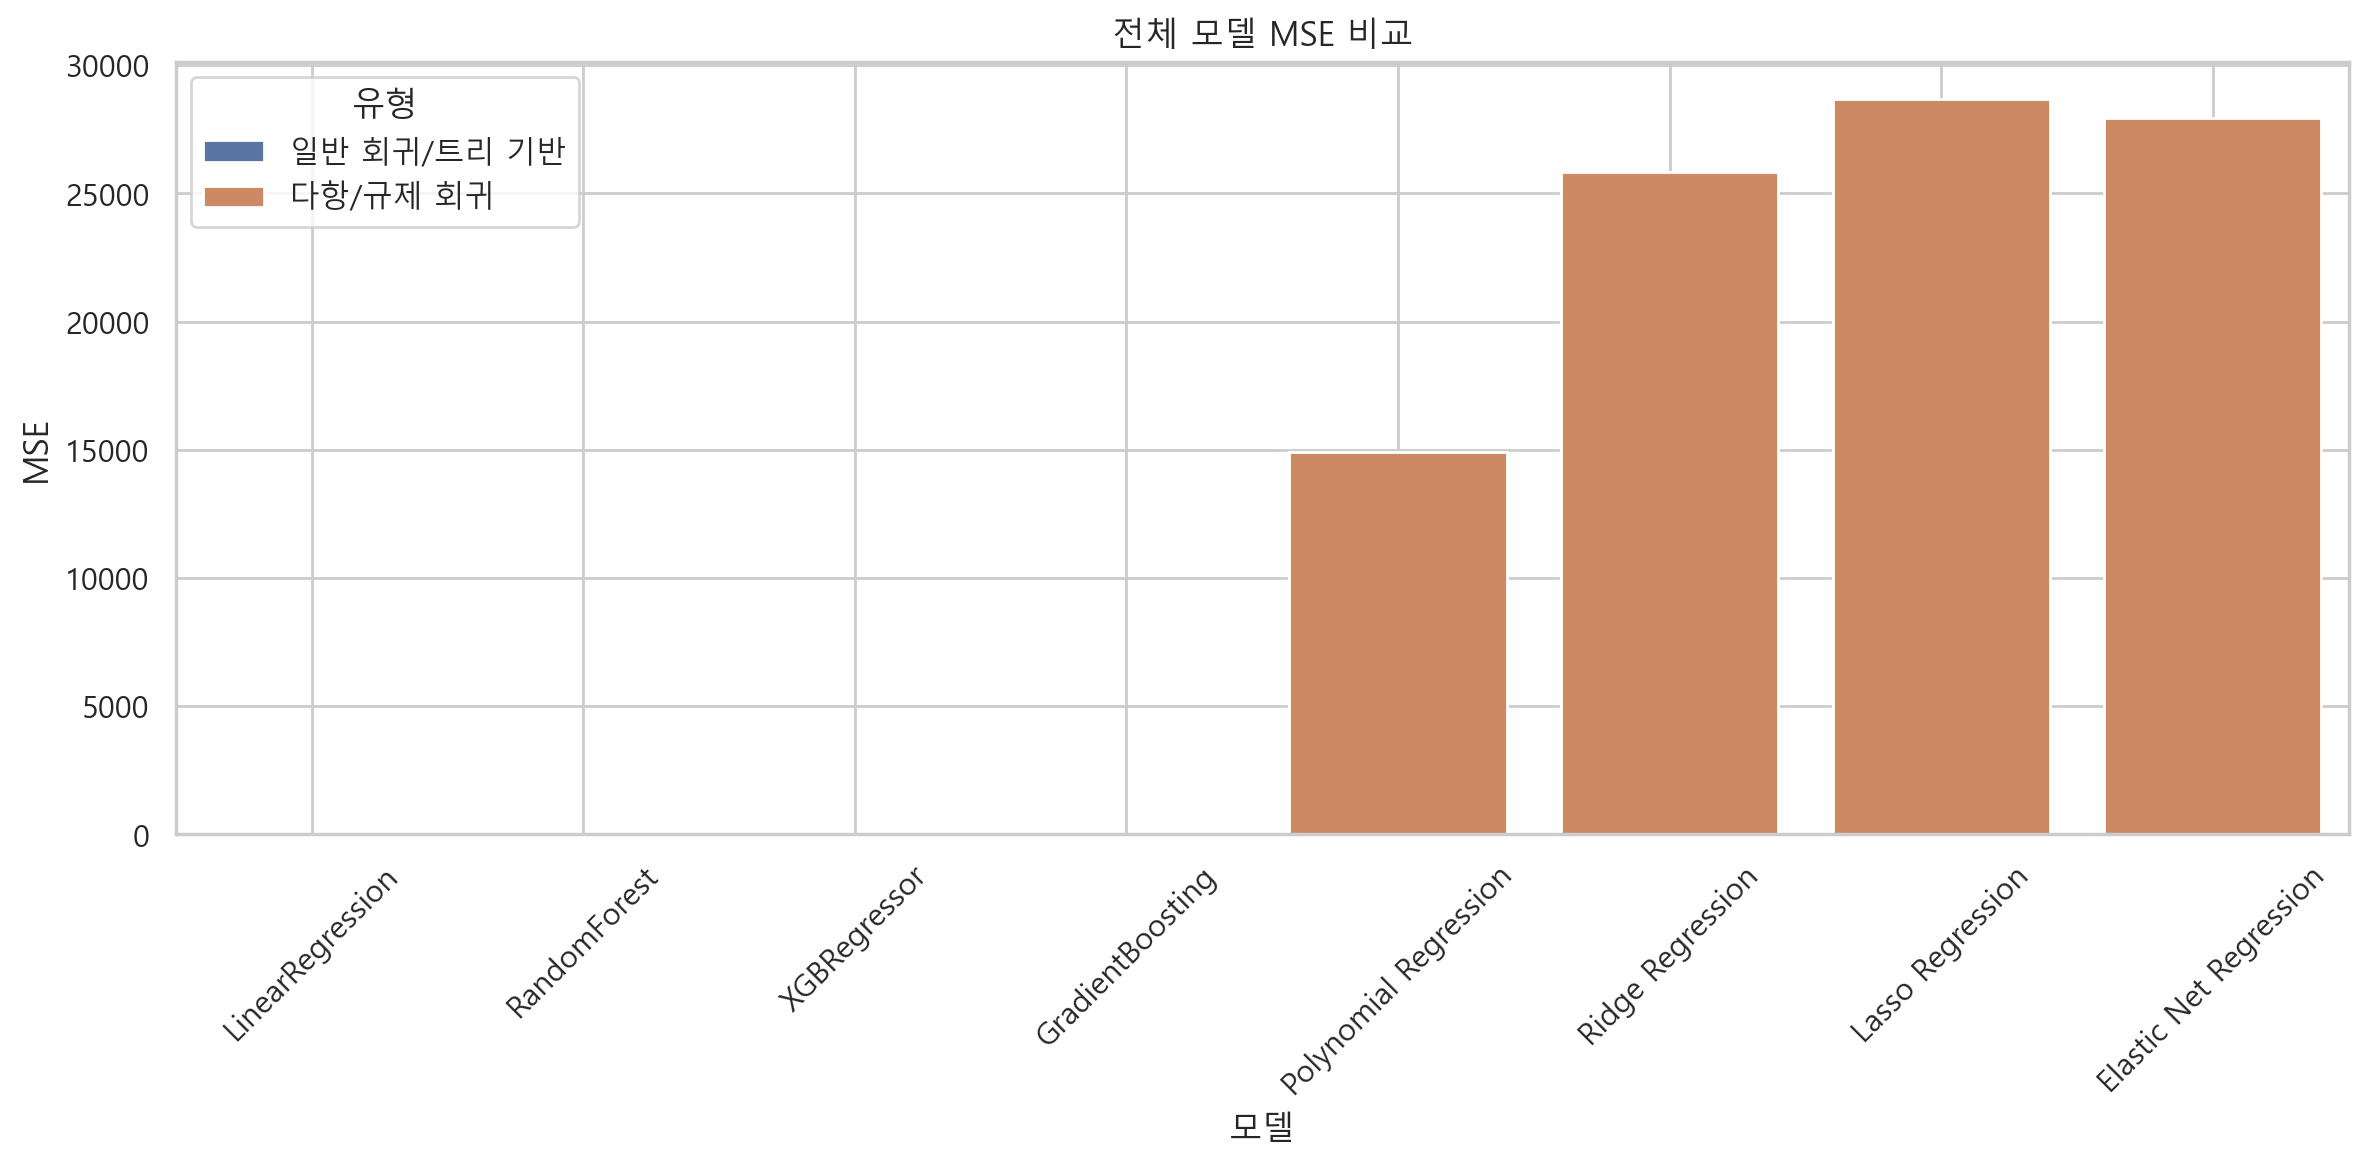

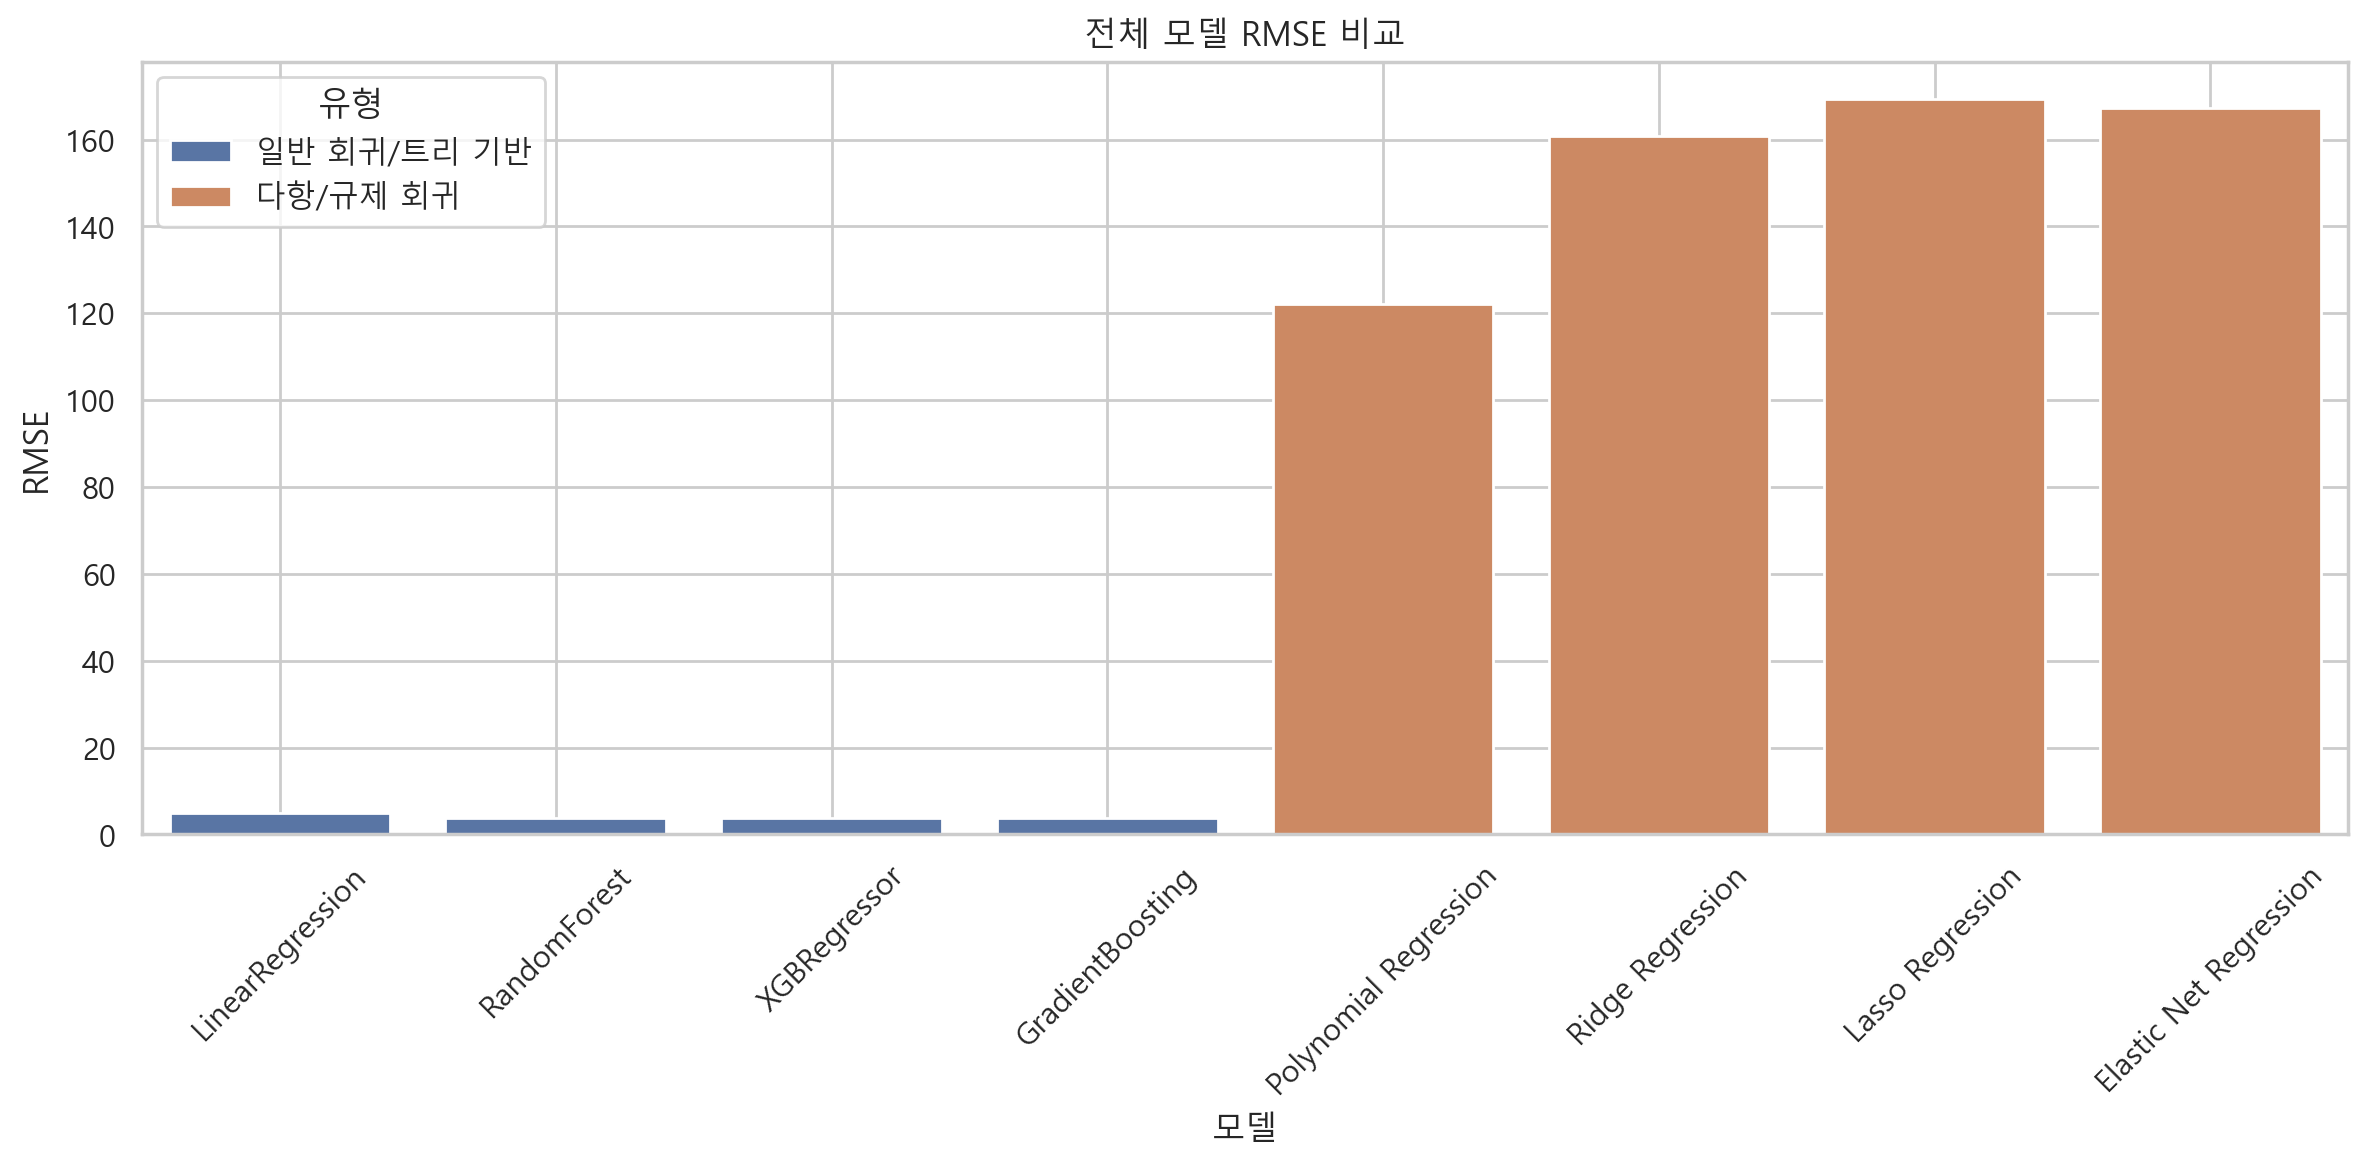

In [26]:
# 기존 일반 모델 성능 데이터프레임
df_general_models = pd.DataFrame({
    '모델': ['LinearRegression', 'RandomForest', 'XGBRegressor', 'GradientBoosting'],
    'MSE': [23.4175, 14.8234, 14.6058, 14.9823],
    'RMSE': [4.8391, 3.8491, 3.8217, 3.8721],
    'R2': [0.7204, 0.8012, 0.8034, 0.7997]
})

df_general_models['유형'] = '일반 회귀/트리 기반'
df_poly_regularized['유형'] = '다항/규제 회귀'
df_combined = pd.concat([df_general_models, df_poly_regularized], ignore_index=True)

# 다항 및 규제 회귀에는 RMSE가 없으므로 추가
df_poly_regularized['RMSE'] = (df_poly_regularized['MSE']) ** 0.5

# 두 데이터프레임 합치기
df_combined = pd.concat([df_general_models, df_poly_regularized], ignore_index=True)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='모델', y='R2', hue='유형', dodge=False)
plt.title('전체 모델 R² 비교 (모델 유형별 색상)')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.legend(title='모델 유형')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='모델', y='MSE', hue='유형', dodge=False)
plt.title('전체 모델 MSE 비교')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='모델', y='RMSE', hue='유형', dodge=False)
plt.title('전체 모델 RMSE 비교')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 12. 전체 최고 성능

In [ ]:
def get_overall_best_model(df, model_col='모델', r2_col='R2', mse_col='MSE'):
    if r2_col not in df.columns or mse_col not in df.columns:
        raise ValueError("DataFrame에 'R2' 또는 'MSE' 컬럼이 없습니다.")
    
    best_row = df.loc[df[r2_col].idxmax()]
    
    print("전체 최고 성능 모델:", best_row[model_col])
    print(f"최고 R² 점수: {best_row[r2_col]:.4f}")
    print(f"MSE: {best_row[mse_col]:.2f}")
    
    return best_row

df_all_models = pd.concat([df_general_models, df_poly_regularized], ignore_index=True)
overall_best = get_overall_best_model(df_all_models)


전체 최고 성능 모델: XGBRegressor
최고 R² 점수: 0.8034
MSE: 14.61
